In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import numpy as np
import torch
from typing import Optional
from scipy.optimize import linear_sum_assignment


def cluster_accuracy(y_true, y_predicted, cluster_number: Optional[int] = None):
    """
    Calculate clustering accuracy after using the linear_sum_assignment function in SciPy to
    determine reassignments.
    :param y_true: list of true cluster numbers, an integer array 0-indexed
    :param y_predicted: list  of predicted cluster numbers, an integer array 0-indexed
    :param cluster_number: number of clusters, if None then calculated from input
    :return: reassignment dictionary, clustering accuracy
    """
    if cluster_number is None:
        cluster_number = (
            max(y_predicted.max(), y_true.max()) + 1
        )  # assume labels are 0-indexed
    count_matrix = np.zeros((cluster_number, cluster_number), dtype=np.int64)
    for i in range(y_predicted.size):
        count_matrix[y_predicted[i], y_true[i]] += 1

    row_ind, col_ind = linear_sum_assignment(count_matrix.max() - count_matrix)
    reassignment = dict(zip(row_ind, col_ind))
    accuracy = count_matrix[row_ind, col_ind].sum() / y_predicted.size
    return reassignment, accuracy

In [3]:
def lp_distance(X, Y, p=1):
    """
    Computes row wise minkowski distances between matrices X and Y
    """
    return torch.sum(torch.abs(X-Y)**p, dim=1)**(1/p)

In [4]:
from transformers import PreTrainedTokenizer
from typing import *

def mask_tokens(inputs: torch.Tensor, tokenizer) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Prepare masked tokens inputs/labels for masked language modeling: 80% MASK, 10% random, 10% original.
    """

    if tokenizer.mask_token is None:
        raise ValueError(
            "This tokenizer does not have a mask token which is necessary for masked language modeling. Remove the --mlm flag if you want to use this tokenizer."
        )

    labels = inputs.clone()
    # We sample a few tokens in each sequence for masked-LM training (with probability args.mlm_probability defaults to 0.15 in Bert/RoBERTa)
    probability_matrix = torch.full(labels.shape, 0.15)
    special_tokens_mask = [
        tokenizer.get_special_tokens_mask(val, already_has_special_tokens=True) for val in labels.tolist()
    ]
    probability_matrix.masked_fill_(torch.tensor(special_tokens_mask, dtype=torch.bool), value=0.0)
    if tokenizer._pad_token is not None:
        padding_mask = labels.eq(tokenizer.pad_token_id)
        probability_matrix.masked_fill_(padding_mask, value=0.0)
    masked_indices = torch.bernoulli(probability_matrix).bool()
    labels[~masked_indices] = -100  # We only compute loss on masked tokens

    # 80% of the time, we replace masked input tokens with tokenizer.mask_token ([MASK])
    indices_replaced = torch.bernoulli(torch.full(labels.shape, 0.8)).bool() & masked_indices
    inputs[indices_replaced] = tokenizer.convert_tokens_to_ids(tokenizer.mask_token)

    # 10% of the time, we replace masked input tokens with random word
    indices_random = torch.bernoulli(torch.full(labels.shape, 0.5)).bool() & masked_indices & ~indices_replaced
    random_words = torch.randint(len(tokenizer), labels.shape, dtype=torch.long)
    inputs[indices_random] = random_words[indices_random]

    # The rest of the time (10% of the time) we keep the masked input tokens unchanged
    return inputs, labels

In [5]:
from torch.utils.data import Dataset, DataLoader


class TextDataset(Dataset):
    def __init__(self, texts, labels):
        
        self.texts = texts
        self.labels = labels


        self.labels = torch.tensor(self.labels, dtype=torch.float)
        
    def __getitem__(self, index):
        return self.texts[index], self.labels[index]

    
    def __len__(self):
        return len(self.texts)

In [6]:
# 20 newsgroups
from sklearn.datasets import fetch_20newsgroups
data = fetch_20newsgroups(
    categories=['comp.graphics', 'talk.religion.misc', 'rec.autos', 'sci.med'],
    remove=('headers', 'footers', 'quotes'),
    shuffle=True,
    random_state=42
)
texts, labels = data.data, data.target

In [7]:
# imdb_reviews
#import tensorflow_datasets as tfds
#from itertools import chain
#
#train_ds = tfds.load('imdb_reviews', split='train', shuffle_files=True)
#test_ds = tfds.load('imdb_reviews', split='test', shuffle_files=True)
#
#texts, labels = [], []
#
#for ds in (train_ds, test_ds):
#    for example in tfds.as_numpy(ds):
#        text, label = example['text'], example['label']
#        texts.append(str(text))
#        labels.append(label)
#
#labels = np.array(labels)

In [8]:
from sklearn.model_selection import train_test_split

texts, _, labels, _ = train_test_split(texts, labels, test_size=0.9, random_state=42)

In [9]:
data = TextDataset(texts, labels)
data_loader = DataLoader(dataset=data, batch_size=8, shuffle=False)

In [10]:
from transformers import DistilBertTokenizer, DistilBertForMaskedLM
import torch

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', return_dict=True)
lm_model = DistilBertForMaskedLM.from_pretrained('distilbert-base-uncased', return_dict=True)
lm_model.to('cuda')

DistilBertForMaskedLM(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): L

In [11]:
from tqdm import tqdm
embeddings = []
for index, text in tqdm(enumerate(texts)):
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True)
    inputs = inputs.to('cuda')
    outputs = lm_model.base_model(**inputs)
    cls_embedding = outputs.last_hidden_state[:,0,:].flatten().cpu().detach().numpy() # 
    embeddings.append(cls_embedding)
embeddings = np.array(embeddings)

214it [00:02, 85.33it/s] 


In [12]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=np.unique(labels).shape[0], n_init=20)

kmeans_cluster = kmeans.fit_predict(embeddings)
kmean_centroids = torch.from_numpy(kmeans.cluster_centers_)
kmean_centroids = kmean_centroids.to('cuda')

In [13]:
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score

print(cluster_accuracy(labels, kmeans_cluster)[1])
print(normalized_mutual_info_score(labels, kmeans_cluster))
print(adjusted_rand_score(labels, kmeans_cluster))

0.7383177570093458
0.575694668467119
0.5275735175840303


In [14]:
import random
initial_centroids = np.array([embeddings[i] for i in (random.randint(0, embeddings.shape[0]-1) for _ in range(np.unique(labels).shape[0]))])
initial_centroids = torch.from_numpy(initial_centroids).to('cuda')
initial_centroids

tensor([[ 0.0395,  0.1006, -0.2078,  ..., -0.1197,  0.3452,  0.5094],
        [-0.1263, -0.2149,  0.2020,  ..., -0.1602,  0.4206,  0.3316],
        [-0.0036,  0.1323, -0.3494,  ..., -0.0133,  0.5460,  0.4757],
        [ 0.0183, -0.0508, -0.2474,  ..., -0.0793,  0.4142,  0.4235]],
       device='cuda:0')

Epoch 0 | Batch: 26 | Combined Loss: 296.1482313954191 | Clustering Loss: 296.1482313954191 | LM Loss 3.097853660583496: : 27it [00:09,  2.70it/s]   


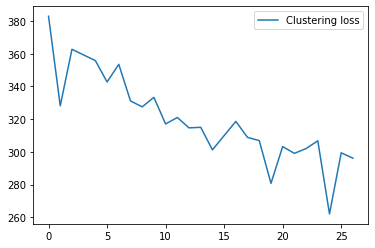

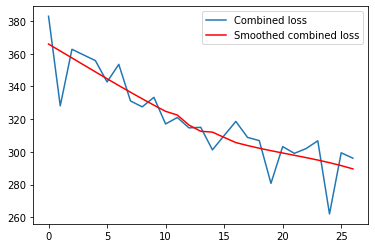

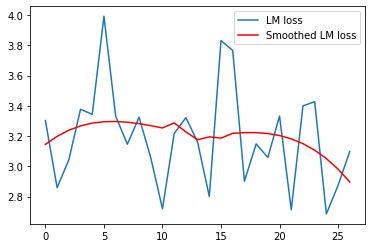

Epoch 1 | Batch: 26 | Combined Loss: 254.62740019758587 | Clustering Loss: 254.62740019758587 | LM Loss 2.612767219543457: : 27it [00:09,  2.74it/s] 


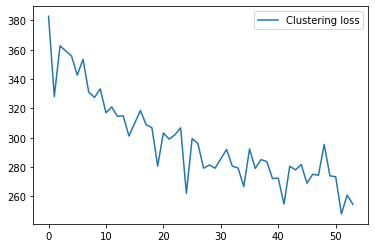

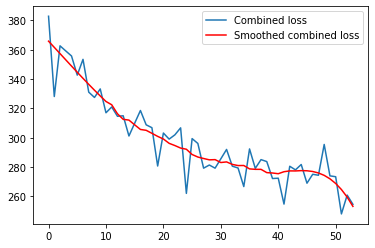

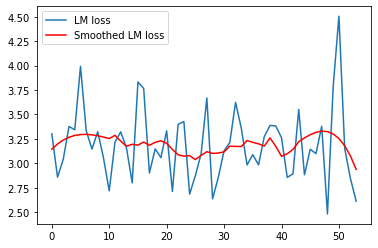

Epoch 2 | Batch: 26 | Combined Loss: 254.57492892011265 | Clustering Loss: 254.57492892011265 | LM Loss 3.0014400482177734: : 27it [00:09,  2.73it/s]


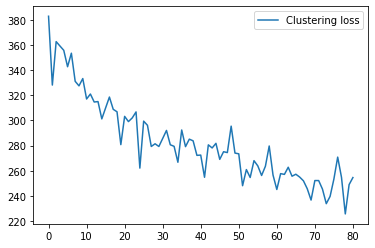

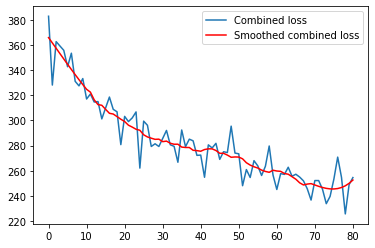

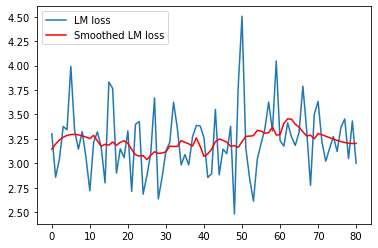

Epoch 3 | Batch: 26 | Combined Loss: 223.62616246144023 | Clustering Loss: 223.62616246144023 | LM Loss 3.020118236541748: : 27it [00:09,  2.71it/s] 


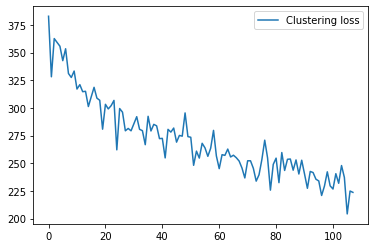

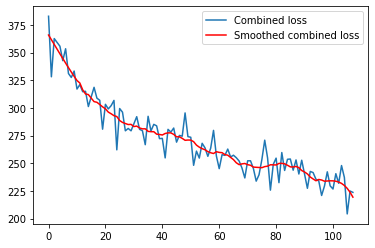

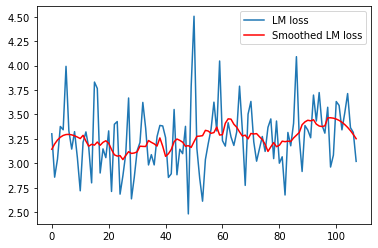

Epoch 4 | Batch: 26 | Combined Loss: 221.36561167430568 | Clustering Loss: 221.36561167430568 | LM Loss 3.089120388031006: : 27it [00:10,  2.69it/s] 


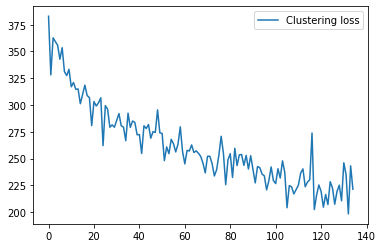

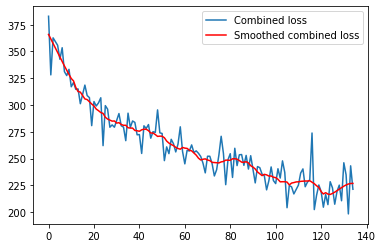

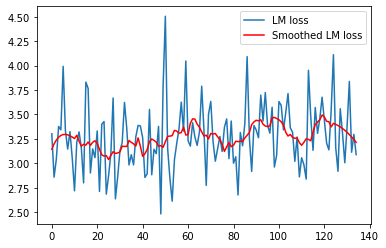

Epoch 5 | Batch: 26 | Combined Loss: 202.7793730560163 | Clustering Loss: 202.7793730560163 | LM Loss 3.1011922359466553: : 27it [00:10,  2.68it/s]  


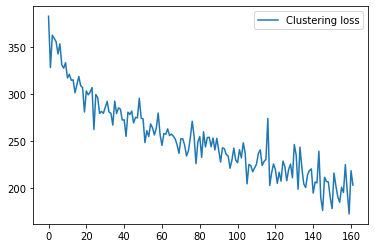

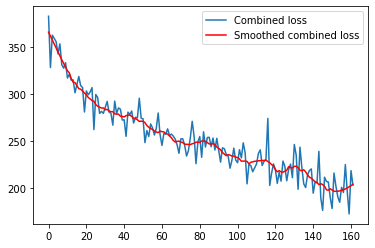

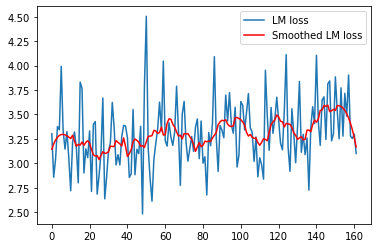

Epoch 6 | Batch: 26 | Combined Loss: 178.80131028172036 | Clustering Loss: 178.80131028172036 | LM Loss 3.344679594039917: : 27it [00:10,  2.65it/s] 


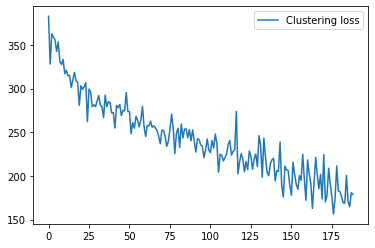

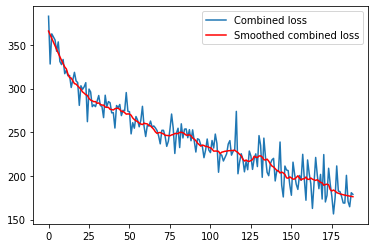

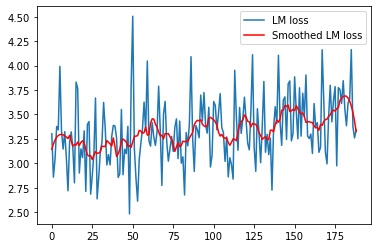

Epoch 7 | Batch: 26 | Combined Loss: 184.81664212733085 | Clustering Loss: 184.81664212733085 | LM Loss 3.7430481910705566: : 27it [00:10,  2.64it/s]


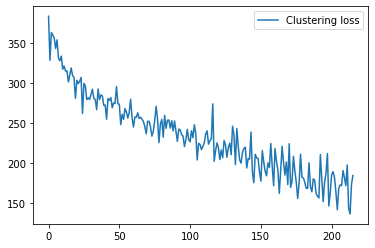

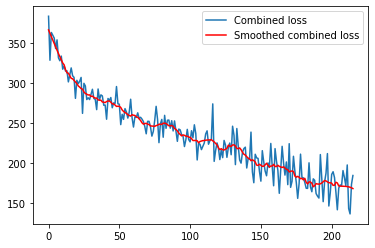

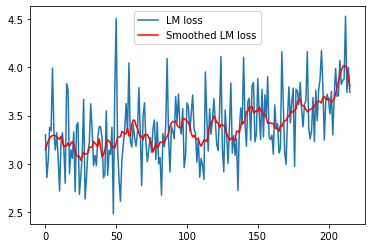

Epoch 8 | Batch: 26 | Combined Loss: 168.15879182034303 | Clustering Loss: 168.15879182034303 | LM Loss 4.004421710968018: : 27it [00:10,  2.68it/s] 


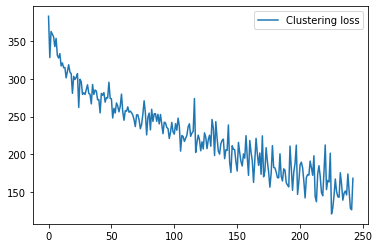

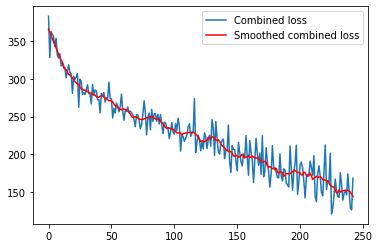

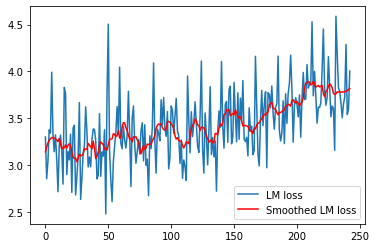

Epoch 9 | Batch: 26 | Combined Loss: 189.93908517744148 | Clustering Loss: 189.93908517744148 | LM Loss 4.3152899742126465: : 27it [00:10,  2.67it/s]


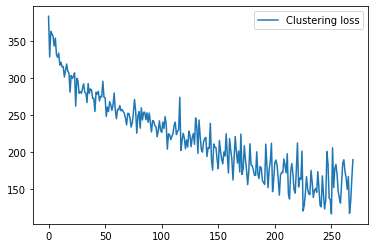

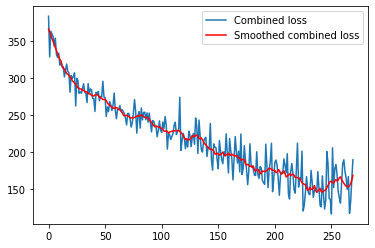

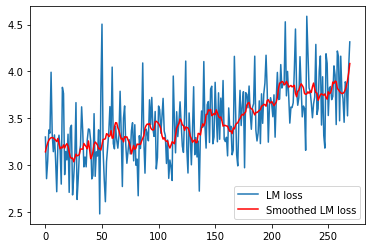

In [15]:
from scipy.signal import savgol_filter

centroids = initial_centroids.clone().to('cuda').requires_grad_(True)
#centroids = torch.Tensor(4, 768).uniform_(-10, 10).to(torch.float64).to('cuda').requires_grad_(True)
#centroids = kmean_centroids.clone().to('cuda').requires_grad_(True)  # go this way (cluster hardening)

#opt = torch.optim.SGD(params=[centroids] + list(lm_model.parameters()), lr=0.001)
opt = torch.optim.AdamW(params=[centroids] + list(lm_model.parameters()), lr = 2e-5, eps = 1e-8 )

lm_model.train()

comb_losses = []
clustering_losses = []
lm_losses = []
c_hist = []
emb_hist = []
for epoch in range(10):
    
    predicted_labels = []
    true_labels = []
    embs = []
    t = [] # improve this asap!

    c_hist.append(centroids.clone().detach().cpu().numpy())
    pbar = tqdm(enumerate(data_loader))
    for batch, batch_data in pbar:
        # lm part 
        texts, labels = batch_data
        inputs = tokenizer(
                    texts,
                    return_tensors='pt',
                    padding=True,
                    truncation=True)
        t.extend(texts)
        #inputs = inputs.to('cuda') # due to lm loss
        
        true_labels.extend(labels)
        
        
        # clustering part
        input_ids = inputs['input_ids'].clone()
        input_ids, labels = mask_tokens(input_ids, tokenizer)
        inputs['input_ids'] = input_ids

        inputs = inputs.to('cuda')
        labels = labels.to('cuda')
        outputs = lm_model(labels=labels, **inputs)
        lm_loss = outputs.loss
        
        
        texts, labels = batch_data
        inputs = tokenizer(
                    texts,
                    return_tensors='pt',
                    padding=True,
                    truncation=True)
        inputs.to('cuda')
        
        # 0. obtain embeddings for each input
        input_embeddings = lm_model.base_model(**inputs).last_hidden_state[:,0,:]
        input_embeddings = input_embeddings.to(torch.float64)
        
        embs.append(input_embeddings.clone().cpu().detach().numpy())

        distances = torch.stack([lp_distance(embedding.unsqueeze(0), centroids) for embedding in input_embeddings])
        #nearest_centroids = torch.argmin(distances, dim=1).cpu().clone().detach()
        nearest_centroids = torch.argmin(distances.cpu().clone().detach(), dim=1)
        distances = torch.transpose(distances, 0, 1)    

        # => shape (n_centroids, n_samples)
        # 2. compute the softmax for each centroid of each distance to each centroid per input sample
        # find min distances for each centroid
        min_distances = torch.min(distances, dim=1).values
        exponentials = torch.exp(-5 * (distances - min_distances.unsqueeze(1)))
        softmax = exponentials / torch.sum(exponentials, dim=1).unsqueeze(1)

        # 3. weight the distanace between each sample and each centroid
        weighted_distances = distances * softmax


        # 4. sum over centroids to obtain loss
        opt.zero_grad()
        
        clustering_loss = weighted_distances.sum(dim=1).mean()
        comb_loss = (lm_loss * 0.0) + (1 * clustering_loss)
        comb_loss.backward()

        opt.step()


        
        predicted_labels.extend(nearest_centroids.numpy())
        clustering_losses.append(clustering_loss.item())
        lm_losses.append(lm_loss.item())
        comb_losses.append(comb_loss.item())
        
        pbar.set_description(f"Epoch {epoch} | Batch: {batch} | Combined Loss: {comb_loss.item()} | Clustering Loss: {clustering_loss.item()} | LM Loss {lm_loss.item()}")
        
        #print(centroids)
    emb_hist.append(embs)
    plt.plot(clustering_losses, label="Clustering loss")
    plt.legend()
    plt.show()
    plt.plot(comb_losses, label="Combined loss")
    plt.plot(savgol_filter(comb_losses, 21, 3), color='red', label="Smoothed combined loss")
    plt.legend()
    plt.show()
    plt.plot(lm_losses, label="LM loss")
    plt.plot(savgol_filter(lm_losses, 21, 3), color='red', label="Smoothed LM loss")
    plt.legend()
    plt.show()

In [16]:
np_centroids = centroids.cpu().detach().numpy()
predicted_labels = np.array(predicted_labels)
true_labels = np.array(true_labels).astype('int')
true_labels.shape, predicted_labels.shape

embs = np.vstack(embs)

In [17]:
print(cluster_accuracy(true_labels, predicted_labels))
print(normalized_mutual_info_score(true_labels, predicted_labels))

({0: 2, 1: 1, 2: 0, 3: 3}, 0.5607476635514018)
0.24161655054468342


In [18]:
np.unique(predicted_labels, return_counts=True)

(array([0, 1, 2, 3]), array([59, 66, 40, 49]))

In [19]:
np.unique(true_labels, return_counts=True)

(array([0, 1, 2, 3]), array([62, 57, 58, 37]))

In [20]:
np.unique(kmeans_cluster, return_counts=True)

(array([0, 1, 2, 3], dtype=int32), array([101,  45,  58,  10]))

In [21]:
from umap import UMAP
from sklearn.decomposition import PCA
umap = UMAP(n_components=2)
Xo = np.vstack([embs, np_centroids])
Xro = umap.fit_transform(Xo)
labels_co = np.concatenate([predicted_labels, [f"Centroid {i}" for i in range(centroids.shape[0])]])
label_kmeans = np.concatenate([kmeans_cluster, [f"Centroid {i}" for i in range(centroids.shape[0])]])

/home/keller/.conda/envs/cuda/lib/python3.8/site-packages/numba/np/ufunc/parallel.py:355: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 10006. The TBB threading layer is disabled.
  warnings.warn(problem)


In [22]:
import plotly.express as px
fig = px.scatter(x=Xro[:, 0], y=Xro[:, 1], color=[f'{i}' for i in labels_co])
fig.show()

In [23]:
import plotly.express as px
fig = px.scatter(x=Xro[:, 0], y=Xro[:, 1], color=[f'{i}' for i in label_kmeans])
fig.show()

In [24]:
(np.vstack(emb_hist[0]) == np.vstack(emb_hist[-1])).all()

False

In [25]:
np.vstack(emb_hist[0]) == np.vstack(emb_hist[-1])

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [26]:
print(* np.array(t)[np.array(predicted_labels) == 1], sep="\n"+"#"*100+"\n\n")

My wife and I looked at, and drove one last fall. This was a 1992 model.
It was WAYYYYYYYYY underpowered. I could not imagine driving it in the
mountains here in Colorado at anything approaching highway speeds. I
have read that the new 1993 models have a newer, improved hp engine. 

I'm quite serious that I laughed in the salesman face when he said "once
it's broken in it will feel more powerful". I had been used to driving a
Jeep 4.0L 190hp engine. I believe the 92's Land Cruisers (Land Yachts)
were 3.0L, the sames as the 4Runner, which is also underpowered (in my
own personal opinion). 

They are big cars, very roomy, but nothing spectacular.

####################################################################################################


####################################################################################################


I would be concerned about how the car was driven and how well it was
maintained.  I own a turbocharged one, and I would never buy a
turboch

In [27]:
inputs

{'input_ids': tensor([[  101,  1011,  1008,  ..., 17841,  1996,   102],
        [  101,   102,     0,  ...,     0,     0,     0],
        [  101,  1045,  2228,  ...,     0,     0,     0],
        [  101,  1045,  2001,  ...,     0,     0,     0],
        [  101,  2045,  2020,  ...,  2006,  2023,   102],
        [  101,  1045,  2031,  ..., 12436, 24965,   102]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 0,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]], device='cuda:0')}

In [28]:
list(data_loader)[-1]

[('-*----\n\nThe two commandments *are* rules; they are merely rules that are\nso vague that they are practically devoid of meaning.  Michael\nSiemon acknowledges this every time he writes that the resolution\nof an argument over them turns on secular and cultural\nassumptions that are independent of these rules.\n \n\nThe commandment to love your neighbor as yourself can be viewed,\nin part, as reminding man that he is not God and cannot act as if\nhe has "ultimate responsibility." Indeed, many traditions present\nan interpretation where believers are supposed to interpret\nloving one\'s neighbor as following various other rules, and\nrelying on their god to make things come out right, precisely\nbecause it would be wrong for man to assume such "ultimate\nresponsibility." Once again, we are confronted with good sounding\ngoo that means whatever the reader wants it to mean. \n\n\nAnd who is to say that this interpretation is "twisted"?  There\nare many passages in the Bible that in the

In [29]:
input_ids

tensor([[  101,  1011,  1008,  ...,   103,  1996,   102],
        [  101,   102,     0,  ...,     0,     0,     0],
        [  101,  1045,  2228,  ...,     0,     0,     0],
        [  101,   103,  2001,  ...,     0,     0,     0],
        [  101,  2045,  2020,  ...,  2006,  2023,   102],
        [  101,  1045,  2031,  ..., 12436, 24965,   102]])

In [30]:
tokenizer.mask_token_id

103

In [31]:
lm_losses

[3.302006721496582,
 2.858403444290161,
 3.0431861877441406,
 3.377002477645874,
 3.343219518661499,
 3.992098331451416,
 3.3320977687835693,
 3.145859718322754,
 3.3241708278656006,
 3.055842399597168,
 2.719055414199829,
 3.2162904739379883,
 3.3214995861053467,
 3.159494638442993,
 2.8002548217773438,
 3.831217050552368,
 3.765986442565918,
 2.901127815246582,
 3.1478073596954346,
 3.058225393295288,
 3.331831455230713,
 2.7122862339019775,
 3.399237632751465,
 3.427330255508423,
 2.684953451156616,
 2.873929500579834,
 3.097853660583496,
 3.6683621406555176,
 2.636695623397827,
 2.8582518100738525,
 3.1284444332122803,
 3.2132794857025146,
 3.6232776641845703,
 3.359326124191284,
 2.9834678173065186,
 3.0887346267700195,
 2.9839353561401367,
 3.2728447914123535,
 3.3877460956573486,
 3.3822107315063477,
 3.263073444366455,
 2.85571026802063,
 2.893062114715576,
 3.5507657527923584,
 2.882983922958374,
 3.1439177989959717,
 3.0991365909576416,
 3.3783340454101562,
 2.482642412185669